# Set up 

In [26]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp
import math

import gzip
import cloudpickle

In [27]:
os.chdir('../../..')
from src import antemll, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/topologyA/omitted_data/')

In [28]:
Teusink_ant ='../../../models/Antimony/topologyA-reg2.ant' 
r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

1.0077414646998453e-15

In [29]:
pt_levels = [0, 0.1, 0.2, 0.3, 0.4 ,0.5, 1.5, 3, 5, 7, 10]
pt_labels = ['knockout','0.1x', '0.2x', '0.3x', '0.4x','0.5x', '1.5x', '3x', '5x', '7x', '10x']

In [30]:
enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

# Leaving out enzyme data

In [31]:
data0 = pd.read_csv('../../../data/interim/generated_data/topologyA-reg2/topologyA-reg2_0.csv')[fluxes+internal+external]
data01 = pd.read_csv('../../../data/interim/generated_data/topologyA-reg2/topologyA-reg2_0.1.csv')[fluxes+internal+external]
data02 = pd.read_csv('../../../data/interim/generated_data/topologyA-reg2/topologyA-reg2_0.2.csv')[fluxes+internal+external]
data03 = pd.read_csv('../../../data/interim/generated_data/topologyA-reg2/topologyA-reg2_0.3.csv')[fluxes+internal+external]
data04 = pd.read_csv('../../../data/interim/generated_data/topologyA-reg2/topologyA-reg2_0.4.csv')[fluxes+internal+external]
data05 = pd.read_csv('../../../data/interim/generated_data/topologyA-reg2/topologyA-reg2_0.5.csv')[fluxes+internal+external]

data15 = pd.read_csv('../../../data/interim/generated_data/topologyA-reg2/topologyA-reg2_1.5.csv')[fluxes+internal+external]
data3 = pd.read_csv('../../../data/interim/generated_data/topologyA-reg2/topologyA-reg2_3.csv')[fluxes+internal+external]
data5 = pd.read_csv('../../../data/interim/generated_data/topologyA-reg2/topologyA-reg2_5.csv')[fluxes+internal+external]
data7 = pd.read_csv('../../../data/interim/generated_data/topologyA-reg2/topologyA-reg2_7.csv')[fluxes+internal+external]
data100 = pd.read_csv('../../../data/interim/generated_data/topologyA-reg2/topologyA-reg2_10.csv')[fluxes+internal+external]

In [32]:
BMCA_obj0 = antemll.antemll(Teusink_ant, data0, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj01 = antemll.antemll(Teusink_ant, data01, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj02 = antemll.antemll(Teusink_ant, data02, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj03 = antemll.antemll(Teusink_ant, data03, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj04 = antemll.antemll(Teusink_ant, data04, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj05 = antemll.antemll(Teusink_ant, data05, '../../../models/sbml/topologyA_cobra.xml')

BMCA_obj15 = antemll.antemll(Teusink_ant, data15, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj3 = antemll.antemll(Teusink_ant, data3, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj5 = antemll.antemll(Teusink_ant, data5, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj7 = antemll.antemll(Teusink_ant, data7, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj100 = antemll.antemll(Teusink_ant, data100, '../../../models/sbml/topologyA_cobra.xml')


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning:

divide by zero encountered in log



../../../models/Antimony/topologyA-reg2_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA-reg2_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA-reg2_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA-reg2_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA-reg2_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA-reg2_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA-reg2_cobra.ant


No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA-reg2_cobra.ant
../../../models/Antimony/topologyA-reg2_cobra.ant


No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA-reg2_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA-reg2_cobra.ant


## Running ADVI

In [8]:
def run_BayesInf(BMCA_obj, n_samp=1):
    enzymes = ['e_' + i for i in r.getReactionIds()]
        
    known_e_inds = []
    omitted_e_inds = []
    for i, e in enumerate(enzymes):
        if e in data100.columns:
            known_e_inds.append(i)
        else: 
            omitted_e_inds.append(i)
    e_inds = np.hstack([known_e_inds, omitted_e_inds]).argsort()

    with pm.Model() as pymc_model:

        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        
        #Protein Expression Priors
        e_measured = pm.Normal('e_measured', mu=1, sigma=0.1, observed=BMCA_obj.en.T)
        e_unmeasured = pm.Normal('e_unmeasured', mu=1, sigma=0.1, shape=(len(omitted_e_inds), len(BMCA_obj.en)))
        e_t = at.concatenate([e_measured, e_unmeasured], axis=0)[e_inds, :]
        pm.Deterministic('e_t', e_t)
        
        chi_t = pm.Normal('chi_t', mu=0, sigma=0.5, observed=BMCA_obj.xn.T)
        y_t = pm.Normal('y_t', mu=0, sigma=0.5, observed=BMCA_obj.yn.T)
        
        likelihood = pm.Deterministic('vn', e_t * (np.ones((len(e_inds), len(BMCA_obj.en))) + pm.math.dot(Ex_t,chi_t) + pm.math.dot(Ey_t,y_t)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
        
        N_ITERATIONS = 20000

        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
    
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=1E-1), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)


    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    if n_samp > 1:
        samples = []
        for i in range(n_samp): 
            samples.append(approx.sample(draws=1000, random_seed=i))
        return samples
    else:
        return approx.sample(draws=1000, random_seed=1)



In [9]:
trace0 = run_BayesInf(BMCA_obj0, n_samp=3)
trace01 = run_BayesInf(BMCA_obj01, n_samp=3)
trace02 = run_BayesInf(BMCA_obj02, n_samp=3)
trace03 = run_BayesInf(BMCA_obj03, n_samp=3)
trace04 = run_BayesInf(BMCA_obj04, n_samp=3)
trace05 = run_BayesInf(BMCA_obj05, n_samp=3)

trace15 = run_BayesInf(BMCA_obj15, n_samp=3)
trace3 = run_BayesInf(BMCA_obj3, n_samp=3)
trace5 = run_BayesInf(BMCA_obj5, n_samp=3)
trace7 = run_BayesInf(BMCA_obj7, n_samp=3)
trace100 = run_BayesInf(BMCA_obj100, n_samp=3)
# 171 min
# 188 min

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log



FloatingPointError: NaN occurred in optimization. 
The current approximation of RV `Ex_kinetic_entries`.ravel()[0] is NaN.
The current approximation of RV `Ex_kinetic_entries`.ravel()[1] is NaN.
The current approximation of RV `Ex_kinetic_entries`.ravel()[2] is NaN.
The current approximation of RV `Ex_kinetic_entries`.ravel()[3] is NaN.
The current approximation of RV `Ex_kinetic_entries`.ravel()[4] is NaN.
The current approximation of RV `Ex_kinetic_entries`.ravel()[5] is NaN.
The current approximation of RV `Ex_kinetic_entries`.ravel()[6] is NaN.
The current approximation of RV `Ex_kinetic_entries`.ravel()[7] is NaN.
The current approximation of RV `Ex_kinetic_entries`.ravel()[8] is NaN.
The current approximation of RV `Ex_kinetic_entries`.ravel()[9] is NaN.
The current approximation of RV `Ex_kinetic_entries`.ravel()[10] is NaN.
The current approximation of RV `Ex_kinetic_entries`.ravel()[11] is NaN.
The current approximation of RV `Ex_kinetic_entries`.ravel()[12] is NaN.
The current approximation of RV `Ex_kinetic_entries`.ravel()[13] is NaN.
The current approximation of RV `Ex_kinetic_entries`.ravel()[14] is NaN.
The current approximation of RV `Ex_kinetic_entries`.ravel()[15] is NaN.
The current approximation of RV `Ex_kinetic_entries`.ravel()[16] is NaN.
The current approximation of RV `Ex_kinetic_entries`.ravel()[17] is NaN.
The current approximation of RV `Ex_kinetic_entries`.ravel()[18] is NaN.
The current approximation of RV `Ex_kinetic_entries`.ravel()[19] is NaN.
The current approximation of RV `Ex_kinetic_entries`.ravel()[20] is NaN.
The current approximation of RV `Ex_kinetic_entries`.ravel()[21] is NaN.
The current approximation of RV `Ex_kinetic_entries`.ravel()[22] is NaN.
The current approximation of RV `Ex_kinetic_entries`.ravel()[23] is NaN.
The current approximation of RV `Ex_kinetic_entries`.ravel()[24] is NaN.
The current approximation of RV `Ex_kinetic_entries`.ravel()[25] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[0] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[1] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[2] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[3] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[4] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[5] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[6] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[7] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[8] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[9] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[10] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[11] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[12] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[13] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[14] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[15] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[16] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[17] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[18] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[19] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[20] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[21] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[22] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[23] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[24] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[25] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[26] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[27] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[28] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[29] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[30] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[31] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[32] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[33] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[34] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[35] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[36] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[37] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[38] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[39] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[40] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[41] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[42] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[43] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[44] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[45] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[46] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[47] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[48] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[49] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[50] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[51] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[52] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[53] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[54] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[55] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[56] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[57] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[58] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[59] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[60] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[61] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[62] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[63] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[64] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[65] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[66] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[67] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[68] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[69] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[70] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[71] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[72] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[73] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[74] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[75] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[76] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[77] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[78] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[79] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[80] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[81] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[82] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[83] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[84] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[85] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[86] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[87] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[88] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[89] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[90] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[91] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[92] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[93] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[94] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[95] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[96] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[97] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[98] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[99] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[100] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[101] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[102] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[103] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[104] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[105] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[106] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[107] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[108] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[109] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[110] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[111] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[112] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[113] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[114] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[115] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[116] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[117] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[118] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[119] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[120] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[121] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[122] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[123] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[124] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[125] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[126] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[127] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[128] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[129] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[130] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[131] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[132] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[133] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[134] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[135] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[136] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[137] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[138] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[139] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[140] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[141] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[142] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[143] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[144] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[145] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[146] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[147] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[148] is NaN.
The current approximation of RV `Ex_capacity_entries`.ravel()[149] is NaN.
The current approximation of RV `Ey_kinetic_entries`.ravel()[0] is NaN.
The current approximation of RV `Ey_kinetic_entries`.ravel()[1] is NaN.
The current approximation of RV `Ey_kinetic_entries`.ravel()[2] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[0] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[1] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[2] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[3] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[4] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[5] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[6] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[7] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[8] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[9] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[10] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[11] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[12] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[13] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[14] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[15] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[16] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[17] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[18] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[19] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[20] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[21] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[22] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[23] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[24] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[25] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[26] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[27] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[28] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[29] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[30] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[31] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[32] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[33] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[34] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[35] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[36] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[37] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[38] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[39] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[40] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[41] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[42] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[43] is NaN.
The current approximation of RV `Ey_capacity_entries`.ravel()[44] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[0] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[1] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[2] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[3] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[4] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[5] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[6] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[7] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[8] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[9] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[10] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[11] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[12] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[13] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[14] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[15] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[16] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[17] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[18] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[19] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[20] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[21] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[22] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[23] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[24] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[25] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[26] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[27] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[28] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[29] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[30] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[31] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[32] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[33] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[34] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[35] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[36] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[37] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[38] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[39] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[40] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[41] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[42] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[43] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[44] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[45] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[46] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[47] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[48] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[49] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[50] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[51] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[52] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[53] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[54] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[55] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[56] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[57] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[58] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[59] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[60] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[61] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[62] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[63] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[64] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[65] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[66] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[67] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[68] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[69] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[70] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[71] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[72] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[73] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[74] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[75] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[76] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[77] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[78] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[79] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[80] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[81] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[82] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[83] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[84] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[85] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[86] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[87] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[88] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[89] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[90] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[91] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[92] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[93] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[94] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[95] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[96] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[97] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[98] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[99] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[100] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[101] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[102] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[103] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[104] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[105] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[106] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[107] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[108] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[109] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[110] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[111] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[112] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[113] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[114] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[115] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[116] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[117] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[118] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[119] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[120] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[121] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[122] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[123] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[124] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[125] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[126] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[127] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[128] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[129] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[130] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[131] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[132] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[133] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[134] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[135] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[136] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[137] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[138] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[139] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[140] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[141] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[142] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[143] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[144] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[145] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[146] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[147] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[148] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[149] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[150] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[151] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[152] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[153] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[154] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[155] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[156] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[157] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[158] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[159] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[160] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[161] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[162] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[163] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[164] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[165] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[166] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[167] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[168] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[169] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[170] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[171] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[172] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[173] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[174] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[175] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[176] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[177] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[178] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[179] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[180] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[181] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[182] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[183] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[184] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[185] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[186] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[187] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[188] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[189] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[190] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[191] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[192] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[193] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[194] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[195] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[196] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[197] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[198] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[199] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[200] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[201] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[202] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[203] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[204] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[205] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[206] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[207] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[208] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[209] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[210] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[211] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[212] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[213] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[214] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[215] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[216] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[217] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[218] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[219] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[220] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[221] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[222] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[223] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[224] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[225] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[226] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[227] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[228] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[229] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[230] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[231] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[232] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[233] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[234] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[235] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[236] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[237] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[238] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[239] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[240] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[241] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[242] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[243] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[244] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[245] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[246] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[247] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[248] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[249] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[250] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[251] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[252] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[253] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[254] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[255] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[256] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[257] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[258] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[259] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[260] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[261] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[262] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[263] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[264] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[265] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[266] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[267] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[268] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[269] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[270] is NaN.
The current approximation of RV `e_unmeasured`.ravel()[271] is NaN.
Try tracking this parameter: http://docs.pymc.io/notebooks/variational_api_quickstart.html#Tracking-parameters

### saving trace data

In [ ]:
with gzip.open("topologyA-reg2_omitEnzymes_traces.pgz", "wb") as f:
            cloudpickle.dump(
                {
                "trace0":trace0,
                "trace01":trace01,
                "trace02":trace02,
                "trace03":trace03,
                "trace04":trace04,
                "trace05":trace05,
                
                "trace15":trace15,
                "trace3":trace3,
                "trace5":trace5,
                "trace7":trace7,
                "trace100":trace100
                },
                f,
            )

# Analysis

In [33]:
picklefolder = '../../../data/results/tracePickles/'
with gzip.open(picklefolder + 'topologyA-reg2_omitEnzymes_traces.pgz', "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')

In [34]:
trace0=traces['trace0']
trace01=traces['trace01']
trace02=traces['trace02']
trace03=traces['trace03']
trace04=traces['trace04']
trace05=traces['trace05']

trace15=traces['trace15']
trace3=traces['trace3']
trace5=traces['trace5']
trace7=traces['trace7']
trace100=traces['trace100']

In [35]:
med_Ex0_advi = util.get_az_mean(trace0)
med_Ex01_advi = util.get_az_mean(trace01)
med_Ex02_advi = util.get_az_mean(trace02)
med_Ex03_advi = util.get_az_mean(trace03)
med_Ex04_advi = util.get_az_mean(trace04)
med_Ex05_advi = util.get_az_mean(trace05)

med_Ex15_advi = util.get_az_mean(trace15)
med_Ex3_advi = util.get_az_mean(trace3)
med_Ex5_advi = util.get_az_mean(trace5)
med_Ex7_advi = util.get_az_mean(trace7)
med_Ex100_advi = util.get_az_mean(trace100)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: 

In [36]:
et0_0 = (trace0[0]['posterior']['e_t']).to_numpy().squeeze()
et0_1 = (trace0[1]['posterior']['e_t']).to_numpy().squeeze()
et0_2 = (trace0[2]['posterior']['e_t']).to_numpy().squeeze()
et0 = np.concatenate([et0_0, et0_1, et0_2])
med_et_advi_0 = np.median(et0, axis=0).transpose()

et01_0 = (trace01[0]['posterior']['e_t']).to_numpy().squeeze()
et01_1 = (trace01[1]['posterior']['e_t']).to_numpy().squeeze()
et01_2 = (trace01[2]['posterior']['e_t']).to_numpy().squeeze()
et01 = np.concatenate([et01_0, et01_1, et01_2])
med_et_advi_01 = np.median(et01, axis=0).transpose()

et02_0 = (trace02[0]['posterior']['e_t']).to_numpy().squeeze()
et02_1 = (trace02[1]['posterior']['e_t']).to_numpy().squeeze()
et02_2 = (trace02[2]['posterior']['e_t']).to_numpy().squeeze()
et02 = np.concatenate([et02_0, et02_1, et02_2])
med_et_advi_02 = np.median(et02, axis=0).transpose()

et03_0 = (trace03[0]['posterior']['e_t']).to_numpy().squeeze()
et03_1 = (trace03[1]['posterior']['e_t']).to_numpy().squeeze()
et03_2 = (trace03[2]['posterior']['e_t']).to_numpy().squeeze()
et03 = np.concatenate([et03_0, et03_1, et03_2])
med_et_advi_03 = np.median(et03, axis=0).transpose()

et04_0 = (trace04[0]['posterior']['e_t']).to_numpy().squeeze()
et04_1 = (trace04[1]['posterior']['e_t']).to_numpy().squeeze()
et04_2 = (trace04[2]['posterior']['e_t']).to_numpy().squeeze()
et04 = np.concatenate([et04_0, et04_1, et04_2])
med_et_advi_04 = np.median(et04, axis=0).transpose()

et05_0 = (trace05[0]['posterior']['e_t']).to_numpy().squeeze()
et05_1 = (trace05[1]['posterior']['e_t']).to_numpy().squeeze()
et05_2 = (trace05[2]['posterior']['e_t']).to_numpy().squeeze()
et05 = np.concatenate([et05_0, et05_1, et05_2])
med_et_advi_05 = np.median(et05, axis=0).transpose()


et15_0 = (trace15[0]['posterior']['e_t']).to_numpy().squeeze()
et15_1 = (trace15[1]['posterior']['e_t']).to_numpy().squeeze()
et15_2 = (trace15[2]['posterior']['e_t']).to_numpy().squeeze()
et15 = np.concatenate([et15_0, et15_1, et15_2])
med_et_advi_15 = np.median(et15, axis=0).transpose()

et3_0 = (trace3[0]['posterior']['e_t']).to_numpy().squeeze()
et3_1 = (trace3[1]['posterior']['e_t']).to_numpy().squeeze()
et3_2 = (trace3[2]['posterior']['e_t']).to_numpy().squeeze()
et3 = np.concatenate([et3_0, et3_1, et3_2])
med_et_advi_3 = np.median(et3, axis=0).transpose()

et5_0 = (trace5[0]['posterior']['e_t']).to_numpy().squeeze()
et5_1 = (trace5[1]['posterior']['e_t']).to_numpy().squeeze()
et5_2 = (trace5[2]['posterior']['e_t']).to_numpy().squeeze()
et5 = np.concatenate([et5_0, et5_1, et5_2])
med_et_advi_5 = np.median(et5, axis=0).transpose()

et7_0 = (trace7[0]['posterior']['e_t']).to_numpy().squeeze()
et7_1 = (trace7[1]['posterior']['e_t']).to_numpy().squeeze()
et7_2 = (trace7[2]['posterior']['e_t']).to_numpy().squeeze()
et7 = np.concatenate([et7_0, et7_1, et7_2])
med_et_advi_7 = np.median(et7, axis=0).transpose()

et100_0 = (trace100[0]['posterior']['e_t']).to_numpy().squeeze()
et100_1 = (trace100[1]['posterior']['e_t']).to_numpy().squeeze()
et100_2 = (trace100[2]['posterior']['e_t']).to_numpy().squeeze()
et100 = np.concatenate([et100_0, et100_1, et100_2])
med_et_advi_100 = np.median(et100, axis=0).transpose()


In [37]:
elasticity_values = np.column_stack([r.getScaledElasticityMatrix().flatten(),
                                med_Ex0_advi, med_Ex01_advi, med_Ex02_advi, med_Ex03_advi, 
                               med_Ex04_advi, med_Ex05_advi,  
                               med_Ex15_advi, med_Ex3_advi, med_Ex5_advi, 
                               med_Ex7_advi, med_Ex100_advi])

elasticities_df = pd.DataFrame(elasticity_values, columns=['gt']+pt_labels, 
                               index=[i + '_' + ii for i in r.getReactionIds() for ii in r.getFloatingSpeciesIds()])
# elasticities_df.to_csv('topologyA-reg2_omitEnzymes_elasticities.csv')

In [38]:
e_slopes = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[0],3) for i in pt_labels]
e_intercepts = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[1],3) for i in pt_labels]
e_r2s = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[2],3) for i in pt_labels]

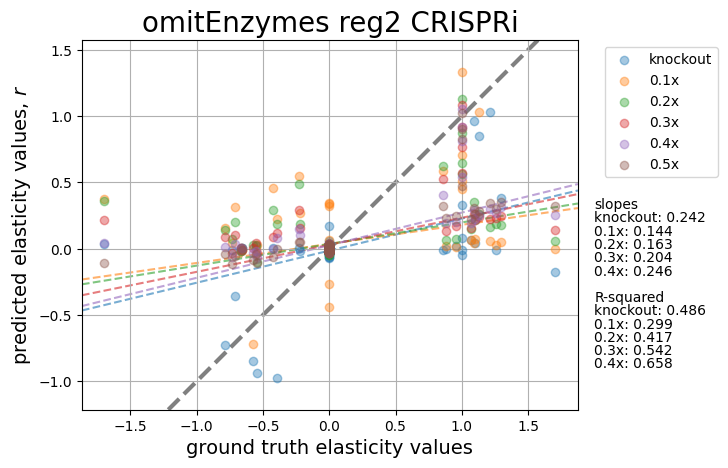

In [24]:
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(elasticities_df['gt'], elasticities_df['knockout'], alpha=0.4, label='knockout', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.1x'], alpha=0.4, label='0.1x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.2x'], alpha=0.4, label='0.2x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.3x'], alpha=0.4, label='0.3x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.4x'], alpha=0.4, label='0.4x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.5x'], alpha=0.4, label='0.5x', zorder=10)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
# plt.title('Parity plot of elasticity values for various \nenzyme perturbation strengths—CRISPRi', size=20)
plt.title('omitEnzymes reg2 CRISPRi', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

left_adjust = 2
line_spacing = 0.1
slope_start = 0.3
r2_start = slope_start-(7*line_spacing)

plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(5):
    plt.axline((0, e_intercepts[i]), slope=e_slopes[i], linestyle='--', alpha=0.6, color=colors[i], zorder=0)

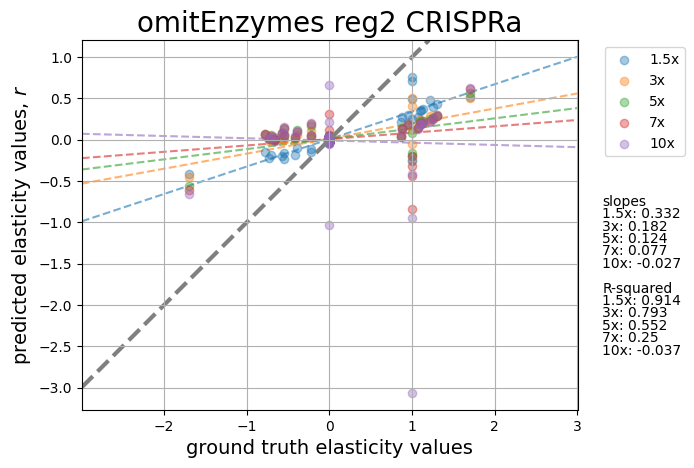

In [25]:
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(elasticities_df['gt'], elasticities_df['1.5x'], alpha=0.4, label='1.5x')
plt.scatter(elasticities_df['gt'], elasticities_df['3x'], alpha=0.4, label='3x')
plt.scatter(elasticities_df['gt'], elasticities_df['5x'], alpha=0.4, label='5x')
plt.scatter(elasticities_df['gt'], elasticities_df['7x'], alpha=0.4, label='7x')
plt.scatter(elasticities_df['gt'], elasticities_df['10x'], alpha=0.4, label='10x')

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1,linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
plt.title('omitEnzymes reg2 CRISPRa', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

left_adjust = 3.3
line_spacing = 0.15
slope_start = -0.8
r2_start = slope_start-(7*line_spacing)

plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels[6:11]):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i+6]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels[6:11]):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i+6]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(5):
    plt.axline((0, e_intercepts[i+6]), slope=e_slopes[i+6], linestyle='--', alpha=0.6, color=colors[i], zorder=0)

In [39]:
# print out MAE for each perturbation strength
MAE = abs(elasticities_df.sub(elasticities_df['gt'], axis=0)).sum()
MAE.to_csv('topologyA-reg2_omitEnzymes_MAE.csv')

Text(0.5, 1.0, 'MAE of elasticity predictions based\non enzyme perturbation strength')

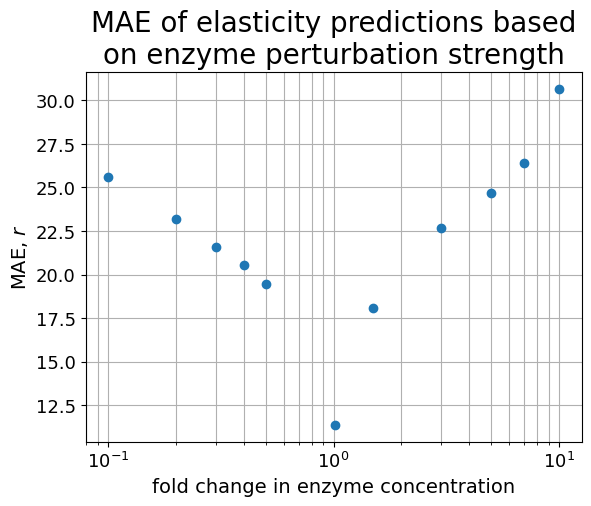

In [31]:
plt.scatter(pt_levels, MAE[1:].values, zorder=10)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xscale('log')
plt.xlabel('fold change in enzyme concentration', size=14)
plt.ylabel('MAE, $\it{r}$', size=14)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title("MAE of elasticity predictions based\non enzyme perturbation strength", size=20)

## Calculating FCCs

In [34]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [35]:
def estimate_CCs(BMCA_obj, Ex, med_et_advi):
    BMCA_obj.vn[BMCA_obj.vn == 0] = 1e-6
    
    a = np.diag(med_et_advi / BMCA_obj.vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(3000, axis=0)

    Ex_ss = a @ Ex
    As = BMCA_obj.N @ np.diag(BMCA_obj.v_star) @ Ex_ss
    bs = BMCA_obj.N @ np.diag(BMCA_obj.v_star)
    bs = bs[np.newaxis, :].repeat(3000, axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(BMCA_obj.N.T))
    identity = identity[np.newaxis,:].repeat(3000, axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    return FCC


### Negative predictions

In [36]:
postFCC01 = estimate_CCs(BMCA_obj01, med_Ex01_advi.reshape((16,11)), med_et_advi_01)
postFCC02 = estimate_CCs(BMCA_obj02, med_Ex02_advi.reshape((16,11)), med_et_advi_02)
postFCC03 = estimate_CCs(BMCA_obj03, med_Ex03_advi.reshape((16,11)), med_et_advi_03)
postFCC04 = estimate_CCs(BMCA_obj04, med_Ex04_advi.reshape((16,11)), med_et_advi_04)

postFCC05 = estimate_CCs(BMCA_obj05, med_Ex05_advi.reshape((16,11)), med_et_advi_05)
postFCC10 = estimate_CCs(BMCA_obj10, med_Ex10_advi.reshape((16,11)), med_et_advi_10)
postFCC15 = estimate_CCs(BMCA_obj15, med_Ex15_advi.reshape((16,11)), med_et_advi_15)
postFCC3 = estimate_CCs(BMCA_obj3, med_Ex3_advi.reshape((16,11)), med_et_advi_3)
postFCC5 = estimate_CCs(BMCA_obj5, med_Ex5_advi.reshape((16,11)), med_et_advi_5)
postFCC7 = estimate_CCs(BMCA_obj7, med_Ex7_advi.reshape((16,11)), med_et_advi_7)
postFCC100 = estimate_CCs(BMCA_obj100, med_Ex100_advi.reshape((16,11)), med_et_advi_100)

In [37]:
rxn_FCCs = [postFCC01, postFCC02, postFCC03, postFCC04, postFCC05, postFCC10, postFCC15, postFCC3, postFCC5, postFCC7, postFCC100]
pt_labels = ['0.1x', '0.2x', '0.3x', '0.4x','0.5x', '1.01x', '1.5x', '3x', '5x', '7x', '10x']

In [38]:
def append_FCC_df(postFCC, label):
    dfs=[]
    
    for idx, rxn in enumerate(r.getReactionIds()):
        # negativity applied here
        df = -pd.DataFrame(postFCC[:,idx,:], columns=r.getReactionIds())
        df['pt_rxn']=[rxn]*len(df)
        dfs.append(df)
    
    w = pd.concat(dfs)
    w['pt_str']=[label]*len(w)
    return w

prd_FCCs = pd.concat([append_FCC_df(rxn_FCCs[i], pt_labels[i]) for i in range(len(rxn_FCCs))])

In [39]:
medPrdFCCs = pd.pivot_table(prd_FCCs, index=['pt_rxn','pt_str'], aggfunc='median', sort=False)
medPrdFCCs.head()

,,vKIL,vLIM,vMIK,vNOV,vOSC,vPAP,vQUE,vROM,vSIE,vTAN,vUNI,vVIC,vWHI,vALP,vYAN,vZUL
pt_rxn,pt_str,,,,,,,,,,,,,,,,
vKIL,0.1x,-15.533240,-0.794854,0.995450,10.175708,2.172240,-3.972160,11.145397,-0.258800,-2.398096,-1.525928,0.165044,-0.046925,-0.247597,-0.895728,-0.663955,0.683444
vLIM,0.1x,1.901405,-1.938732,-0.128556,-1.314133,0.080827,-0.805006,0.331748,-0.016531,0.846097,0.120241,-0.073794,1.727504,-0.525108,0.091156,-1.408126,0.111009
vMIK,0.1x,-21.345486,-1.230992,0.469553,15.022101,3.245524,-5.670594,16.721704,-0.385145,-3.970920,-2.247582,0.269141,-0.869820,-0.154057,-1.431852,-0.413119,0.991542
vNOV,0.1x,-19.227302,-1.110415,1.321561,12.509286,2.942353,-5.131238,15.124634,-0.347813,-3.601698,-2.144136,0.254797,-0.708897,-0.140629,-1.256222,-0.377110,0.892827
vOSC,0.1x,1.901405,0.061268,-0.128556,-1.314133,-1.919173,-0.805006,0.331748,-0.016531,0.846097,0.120241,-0.073794,1.727504,-0.525108,0.091156,-1.408126,0.111009


### Graphing the averaged differences between ground truth and predicted distributions

In [ ]:
# for each reaction that can be perturbed
for rxn in r.getReactionIds():
    # locate the applicable rows in the medPrdFCCs df
    a = medPrdFCCs.loc[rxn]
    gtvals = np.repeat(gtFCC[rxn].values, repeats=len(pt_labels), axis=0).reshape((len(pt_labels), -1))
    # calculate the absolute difference...
    absDifs = a - gtvals
    # and the relative difference
    relDifs = absDifs/gtvals
    
    # plot both graphs 
    f1 = plt.figure(figsize=(16, 10))
    absDifs.T.plot(kind='bar')
    # alternate color each group of reactions so it is easier to see
    for i in range(8):
            plt.axvspan(2*i + 0.5, 2*i + 1.5, alpha=0.1)
    plt.axhline(0, c='gray')
    plt.ylim((-1,1))
    plt.legend(loc='lower right')
    plt.title(f'ADVI predictions for {rxn} FCCs given all data--absDifs')
"""
    f2 = plt.figure(figsize=(16, 10))
    relDifs.T.plot(kind='bar')
    # alternate color each group of reactions so it is easier to see
    for i in range(8):
            plt.axvspan(2*i + 0.5, 2*i + 1.5, alpha=0.1)
    plt.axhline(0, c='gray')
    plt.ylim((-10,10))
    plt.legend(loc='lower right')
    plt.title(f'ADVI predictions for {rxn} FCCs given all data--relDifs')
"""    

In [ ]:
plt.close("all")

## Evaluating FCC ranking

In [40]:
## ground truth FCC rankings

gtFCC=pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
gtFCC = pd.DataFrame(np.select([m1], [float('Nan')], gtFCC), columns=gtFCC.columns, index=gtFCC.index)
gtFCC_rankings= gtFCC.rank(axis=1, ascending=False, na_option='keep')

a = gtFCC_rankings.loc['vYAN']

### via Spearman rank coefficients

In [41]:
def calculate_FCC_med_rankings(postFCC, reaction='vYAN'):
    postFCC_med=pd.DataFrame(np.median(postFCC, axis=0), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
    m1 = postFCC_med.index.values[:, None] == postFCC_med.columns.values
    postFCC = pd.DataFrame(np.select([m1], [float('Nan')], postFCC_med), columns=postFCC_med.columns, index=postFCC_med.index)
    postFCC_rankings= postFCC.rank(axis=1, ascending=False, na_option='keep')
    
    return postFCC_rankings.loc[reaction]
    

In [42]:
from scipy.stats import spearmanr

def bootstrap_spearman(x, y, num_bootstrap=1000, alpha=0.05):
    n = len(x)
    corr_list = []

    # Original Spearman correlation
    corr_original, p_value = spearmanr(x, y)

    for _ in range(num_bootstrap):
        # Generate bootstrap samples
        indices = np.random.randint(0, n, n)
        x_bootstrap = [x[i] for i in indices]
        y_bootstrap = [y[i] for i in indices]

        # Calculate Spearman correlation for the bootstrap sample
        corr, _ = spearmanr(x_bootstrap, y_bootstrap)
        corr_list.append(corr)

    # Convert to numpy array for convenience
    corr_list = np.array(corr_list)
    
    # Calculate the confidence intervals
    lower_bound = np.percentile(corr_list, (alpha/2) * 100)
    upper_bound = np.percentile(corr_list, (1 - alpha/2) * 100)
    
    return corr_original, p_value, lower_bound, upper_bound

In [43]:
spearman_coefficients = []
p_values = []
confidence_intervals = []
b_list = []
for FCC in rxn_FCCs:
    b = calculate_FCC_med_rankings(FCC)
    b_list.append(b)
    spearman_r, p_value, lower_ci, upper_ci = bootstrap_spearman(a.dropna(), b.dropna())
    spearman_coefficients.append(spearman_r)
    p_values.append(p_value)
    confidence_intervals.append((lower_ci, upper_ci))


In [44]:
spearman_df = pd.DataFrame(spearman_coefficients, columns=['r'], index=pt_labels)
spearman_df['p-value'] = p_values
spearman_df['lower'] = [i[0] for i in confidence_intervals]
spearman_df['upper'] = [i[1] for i in confidence_intervals]
spearman_df

,r,p-value,lower,upper
0.1x,-0.021429,0.939578,-0.534436,0.542995
0.2x,0.367857,0.177342,-0.182653,0.760870
0.3x,0.260714,0.347979,-0.312787,0.717962
0.4x,0.792857,0.000422,0.486412,0.935197
0.5x,0.539286,0.038022,-0.032310,0.917032
1.01x,0.271429,0.327789,-0.412676,0.741416
1.5x,0.600000,0.018050,0.068940,0.887945
3x,0.310714,0.259667,-0.228611,0.676588
5x,0.221429,0.427714,-0.439450,0.757732
7x,0.414286,0.124715,-0.207361,0.891304


In [45]:
spearman_df.to_csv('topologyA_reg2_omitEnzymes_spr.csv')

In [ ]:
plt.bar(pt_labels, [i[0] for i in spearman_coefficients], alpha=0.5, color='r')
plt.grid()

for i, txt in enumerate([i[1].round(3) for i in spearman_coefficients]):
    plt.annotate(txt, (pt_labels[i], [i[0] for i in spearman_coefficients][i]), ha='center')

plt.title("Spearman rank correlation coefficients by perturbation strength")
plt.xlabel('perturbation level')
plt.ylabel('Spearman $\it{r}$')
plt.ylim((0, 1.05))

In [ ]:
plt.bar(pt_labels, [i[0] for i in spearman_coefficients], alpha=0.5, color='r')
plt.grid()

for i, txt in enumerate([i[1].round(3) for i in spearman_coefficients]):
    plt.annotate(txt, (pt_labels[i], [i[0] for i in spearman_coefficients][i]), ha='center')

plt.title("Spearman rank correlation coefficients by perturbation strength")
plt.xlabel('perturbation level')
plt.ylabel('Spearman $\it{r}$')
plt.ylim((-1, 1.05))

### evaluating top five rankings

In [ ]:
ranked_b_list = [b.sort_values().reset_index().set_index('vYAN') for b in b_list]
q = pd.concat(ranked_b_list, axis=1)
q['gt'] = a.sort_values().reset_index().set_index('vYAN')
q.columns = pt_labels + ['gt']
q = q[['gt'] + pt_labels]
q

In [ ]:
q.to_csv('topologyA-reg2_omitEnzymes_rankings.csv')